## Construct K-NN (7-NN) graph based on audio and visual based pairwise similarity between nodes (utterances)

In [2]:
import numpy as np, argparse, time, pickle, random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from dataloader import IEMOCAPDataset

import random

import os
import pickle
from scipy.spatial.distance import cdist
from scipy import ndimage
import numpy as np

import dgl
import time
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib

#### Output of the trainset or testset contains a Tensor of num_samples data.

Each sample consists:  
{N_Utter is the number of utterances in one data sample}  

0 -> text features; dim: N_Utter x 100  
1 -> visual features; dim: N_Utter x 512  
2 -> audio features; dim: N_utter x 100  
3 -> speaker gender ([1,0] for Male; [0,1] for Female)  
4 -> ones Tensor of size N_Utter  
5 -> labels of each utterance; label index mapping = {'hap':0, 'sad':1, 'neu':2, 'ang':3, 'exc':4, 'fru':5}  
6 -> video key; eg. Ses05F_script01_2  


In [54]:
def sigma(dists, kth=7):
    # Get k-nearest neighbors for each node
    knns = np.partition(dists, kth, axis=-1)[:, kth::-1]

    # Compute sigma and reshape
    sigma = knns.sum(axis=1).reshape((knns.shape[0], 1))/kth
    return sigma + 1e-8 # adding epsilon to avoid zero value of sigma

def compute_adjacency_matrix(audio, visual, use_audio=True, use_visual=True, kth=7):
    # audio = audio.reshape(-1, 2)
    
    if use_audio and use_visual:
        audio_dist = cdist(audio, audio)     # Compute audio based distance
        visual_dist = cdist(visual, visual)  # Compute visual based distance

        # Compute adjacency
        A = np.exp(- (audio_dist/sigma(audio_dist))**2 - (visual_dist/sigma(visual_dist))**2 )
        
    elif use_audio:
        audio_dist = cdist(audio, audio)     # Compute audio based distance
        
        # Compute adjacency
        A = np.exp(- (audio_dist/sigma(audio_dist))**2)
        
    elif use_visual:
        visual_dist = cdist(visual, visual)  # Compute visual based distance
        
        # Compute adjacency
        A = np.exp(- (visual_dist/sigma(visual_dist))**2)
        
    # Convert adjacency to symmetric matrix
    A = 0.5 * (A + A.T)
    A[np.diag_indices_from(A)] = 0
    return A

def compute_edges_list(A, kth=7+1):
    
    # Get k-similar neighbor indices for each node
    if 1==1:   
        num_nodes = A.shape[0]
        new_kth = num_nodes - kth
        knns = np.argpartition(A, new_kth-1, axis=-1)[:, new_kth:-1]
        knns_d = np.partition(A, new_kth-1, axis=-1)[:, new_kth:-1]
    else:
        knns = np.argpartition(A, kth, axis=-1)[:, kth::-1]
        knns_d = np.partition(A, kth, axis=-1)[:, kth::-1]
    return knns, knns_d

In [77]:
class IEMOCAP_KNN_Graph(torch.utils.data.Dataset):
    def __init__(self, split, use_audio=True, use_visual=True):
        self.split = split
        
        if split == 'train':
            self.dataset = IEMOCAPDataset()
        else:
            self.dataset = IEMOCAPDataset(train=False)
        
        self.use_audio = use_audio
        self.use_visual = use_visual
        
        self.n_samples = len(self.dataset)
        self._prepare()
        
    def _prepare(self):
        t0 = time.time()
        print("[I] Preparing IEMOCAPDataset as a 7-NN similarity graph based ...")
        self.adj_matrices, self.node_features, self.edges_lists, self.labels = [], [], [], []
        for sample in self.dataset:
            visual, audio = sample[1], sample[2]
            A = compute_adjacency_matrix(audio, visual, self.use_audio, self.use_visual)
            edges_list, _ = compute_edges_list(A)

            self.node_features.append(sample[0])      # using text features as node features
            self.adj_matrices.append(A)
            self.edges_lists.append(edges_list)
            self.labels.append(sample[5])
        print("[I] Finished preparation after {:.4f}s".format(time.time()-t0))
            
    def __len__(self):
        return self.n_samples

    def __getitem__(self, index):
        g = dgl.DGLGraph()
        g.add_nodes(self.node_features[index].shape[0])
        g.ndata['feat'] = torch.Tensor(self.node_features[index])
        for src, dsts in enumerate(self.edges_lists[index]):
            g.add_edges(src, dsts[dsts!=src])

        return g, self.labels[index]

## Drawing Sample Graphs of the constructed 7-NN Graphs

### Using only audio features for similarity computation between pair-wise nodes

In [78]:
trainset = IEMOCAP_KNN_Graph(split='train', use_audio=True, use_visual=False)
testset = IEMOCAP_KNN_Graph(split='train', use_audio=True, use_visual=False)

[I] Preparing IEMOCAPDataset as a 7-NN similarity graph based ...
[I] Finished preparation after 0.3326s
[I] Preparing IEMOCAPDataset as a 7-NN similarity graph based ...
[I] Finished preparation after 0.3095s


Number of utterances:  37
Labels of utterances: 
 tensor([5, 2, 5, 5, 2, 5, 2, 5, 2, 5, 2, 5, 5, 2, 5, 2, 5, 2, 5, 2, 5, 5, 1, 1,
        5, 5, 5, 2, 2, 2, 5, 3, 2, 2, 5, 2, 1])


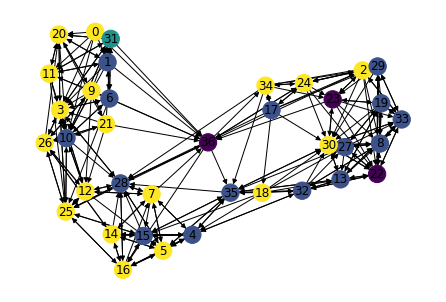

In [92]:
sample = np.random.choice(len(trainset))
g_sample = trainset[sample][0]
print("Number of utterances: ", len(trainset[sample][1]))
print("Labels of utterances: \n", trainset[sample][1])
node_labels = trainset[sample][1]
nx.draw(g_sample.to_networkx(), with_labels=True, node_color=node_labels)
plt.show()

### Using only visual features for similarity computation between pair-wise nodes

In [74]:
trainset = IEMOCAP_KNN_Graph(split='train', use_audio=False, use_visual=True)
testset = IEMOCAP_KNN_Graph(split='train', use_audio=False, use_visual=True)

[I] Preparing IEMOCAPDataset as a 7-NN similarity graph based ...
[I] Finished preparation after 0.4891s
[I] Preparing IEMOCAPDataset as a 7-NN similarity graph based ...
[I] Finished preparation after 0.4694s


Number of utterances:  52
Labels of utterances: 
 tensor([5, 5, 2, 5, 5, 5, 5, 5, 2, 2, 2, 5, 5, 5, 5, 2, 5, 5, 5, 2, 5, 2, 5, 2,
        2, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2,
        2, 2, 2, 2])


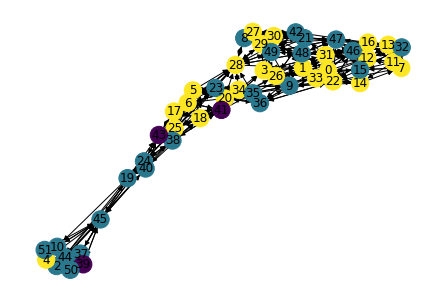

In [100]:
sample = np.random.choice(len(trainset))
g_sample = trainset[sample][0]
print("Number of utterances: ", len(trainset[sample][1]))
print("Labels of utterances: \n", trainset[sample][1])
node_labels = trainset[sample][1]
nx.draw(g_sample.to_networkx(), with_labels=True, node_color=node_labels)
plt.show()

### Using both audio and visual features for similarity computation between pair-wise nodes

In [75]:
trainset = IEMOCAP_KNN_Graph(split='train', use_audio=True, use_visual=True)
testset = IEMOCAP_KNN_Graph(split='train', use_audio=True, use_visual=True)

[I] Preparing IEMOCAPDataset as a 7-NN similarity graph based ...
[I] Finished preparation after 0.5242s
[I] Preparing IEMOCAPDataset as a 7-NN similarity graph based ...
[I] Finished preparation after 0.5239s


Number of utterances:  42
Labels of utterances: 
 tensor([0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 0, 4, 0, 4, 0, 0, 0, 4, 0,
        4, 0, 4, 0, 4, 4, 4, 0, 4, 4, 0, 4, 0, 4, 0, 4, 0, 2])


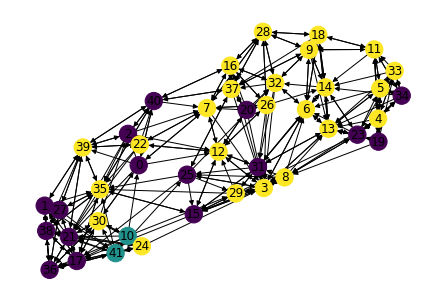

In [101]:
sample = np.random.choice(len(trainset))
g_sample = trainset[sample][0]
print("Number of utterances: ", len(trainset[sample][1]))
print("Labels of utterances: \n", trainset[sample][1])
node_labels = trainset[sample][1]
nx.draw(g_sample.to_networkx(), with_labels=True, node_color=node_labels)
plt.show()